In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import h5py


from models import *
from utils import *

f_train = h5py.File("../data/QG_Images/quark-gluon_train-set_n793900.hdf5","r")
f_test_1 = h5py.File("../data/QG_Images/quark-gluon_test-set_n10000.hdf5","r")
f_test_2 = h5py.File("../data/QG_Images/quark-gluon_test-set_n139306.hdf5","r")

print(f_train.keys())
print(f_test_1.keys())
print(f_test_2.keys())

Device: cuda
<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>
<KeysViewHDF5 ['X', 'y']>
<KeysViewHDF5 ['X_jets', 'm0', 'pt', 'y']>


In [2]:
X_train = f_train.get("X_jets")
y_train = f_train.get("y")

X_test1 = f_test_1.get("X")
y_test1 = f_test_1.get("y")

X_test2 = f_test_2.get("X_jets")
y_test2 = f_test_2.get("y")
pt_test2 = f_test_2.get("pt")
m_test2 = f_test_2.get("m0")

In [3]:
print(len(X_train), len(X_test1), len(X_test2))

793900 10000 139306


In [4]:
pt_test2.shape

print(pt_test2[:10])

[107.45191  133.12431   88.46564  111.72106  110.947655 111.129745
  87.034294  90.747     93.22315  105.96356 ]


In [5]:
m_test2.shape

(139306,)

In [6]:
# visualize_average_images(X_train[:10000], y_train[:10000])
# visualize_average_images(X_train[:10000], y_train[:10000], num=1)

# visualize_diff_average_images(X_train[:10000], y_train[:10000])

In [7]:
dataset = QG_Images(images=X_test1[:5, :, :, 2], labels=y_test1)
print(dataset[0])
print(dataset[1])
print(dataset[2])

Data(x=[17, 1], y=[1], pos=[17, 2], num_nodes=17)
Data(x=[17, 1], y=[1], pos=[17, 2], num_nodes=17)
Data(x=[18, 1], y=[1], pos=[18, 2], num_nodes=18)


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/dataset.py:247: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [8]:
dataset = QG_Images(images=X_test1[:5, :, :, 1], labels=y_test1)
print(dataset[0])
print(dataset[1])

Data(x=[17, 1], y=[1], pos=[17, 2], num_nodes=17)
Data(x=[17, 1], y=[1], pos=[17, 2], num_nodes=17)


In [9]:
dataset = QG_Images(images=X_test1[:, :, :, 0], labels=y_test1)
print(len(dataset))
print(dataset[0])
print(dataset[1])
print(torch.min(dataset[:].x), torch.max(dataset[:].x))

10000
Data(x=[17, 1], y=[1], pos=[17, 2], num_nodes=17)
Data(x=[17, 1], y=[1], pos=[17, 2], num_nodes=17)
tensor(1.0006e-05) tensor(0.2453)


## Contrastive

In [10]:
EPOCH = 1

/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/torch_geometric/data/dataset.py:247: UserWarning: The `pre_filter` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-fitering technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


Data(x=[15, 1], y=[1], pos=[15, 2], num_nodes=15, edge_index=[2, 225])
Node degree: 15.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


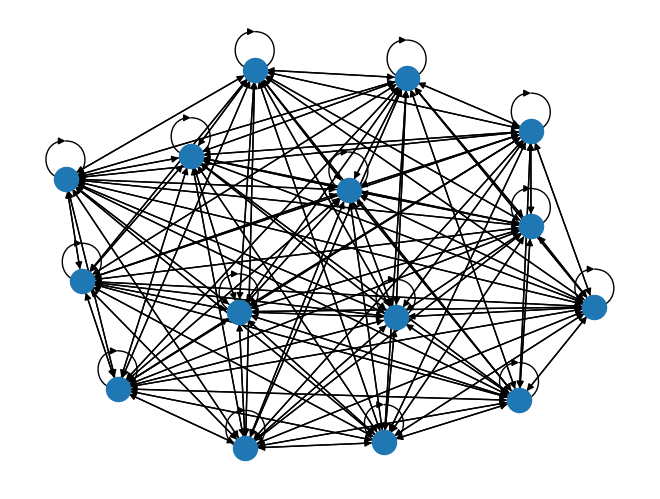

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


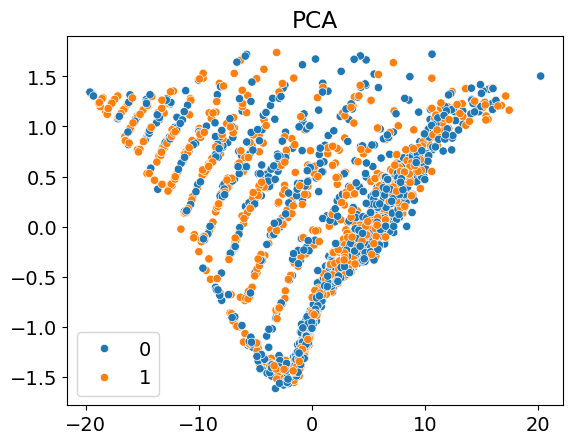

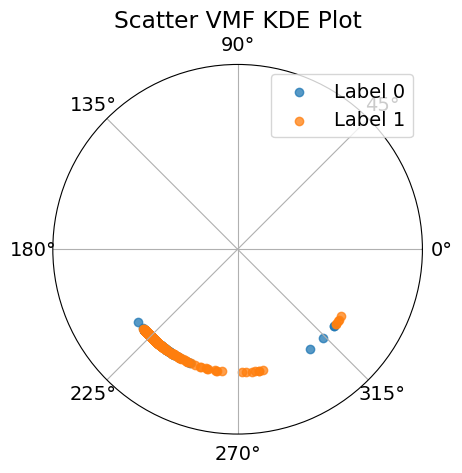

In [11]:
from qml_ssl.utils import vmf_kde_on_circle, pca_proj, tsne_proj, plot_training


dataset = QG_Images(images=X_test1[:, :, :, 0], labels=y_test1)
total_size = 10000
dataset = dataset[:total_size]

train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

batch_size = 32

k = 15

dataset.transform = T.Compose([TopKIntensity(k=k), KNNGroup(k=15, attr_name='x')])
sample = dataset[10]
print(sample)

print(f'Node degree: {sample.num_edges / sample.num_nodes:.2f}')
print(f'Has isolated nodes: {sample.has_isolated_nodes()}')
print(f'Has self-loops: {sample.has_self_loops()}')
print(f'Is undirected: {sample.is_undirected()}')
nx.draw(pyg.utils.to_networkx(dataset[10]))
plt.show()

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = pyg_loader.DataLoader(train_dataset, batch_size=batch_size, num_workers = 4)
val_loader = pyg_loader.DataLoader(val_dataset, batch_size=batch_size, num_workers = 4)
test_loader = pyg_loader.DataLoader(test_dataset, batch_size=batch_size, num_workers = 4)

gcn_encoder = GCN_Encoder()

Contrastive_Graph_pl = ModelPL_Contrastive(model=gcn_encoder, learning_rate=0.001)

logger = pl.loggers.CSVLogger(save_dir='logs', name='Contrastive_Graph_image_pl', version=0)

summary_callback = pl.callbacks.ModelSummary(max_depth=8)
callbacks = [summary_callback]

embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

In [12]:
trainer_contrastive = pl.Trainer(max_epochs=EPOCH, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_contrastive.fit(Contrastive_Graph_pl, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_contrastive.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/Contrastive_Graph_image_pl/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and

Epoch 0: 100%|██████████| 251/251 [00:06<00:00, 36.15it/s, loss=2.75, v_num=0, val_loss=2.760, train_loss=2.770]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 251/251 [00:06<00:00, 36.03it/s, loss=2.75, v_num=0, val_loss=2.760, train_loss=2.770]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/Contrastive_Graph_image_pl/version_0/checkpoints/epoch=0-step=188-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weight

Testing DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 55.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.7595877647399902     │
└───────────────────────────┴───────────────────────────┘

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/src/qml_contrastive/utils.py:61: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=labels, palette=sns.color_palette("tab10")).set(title="PCA")


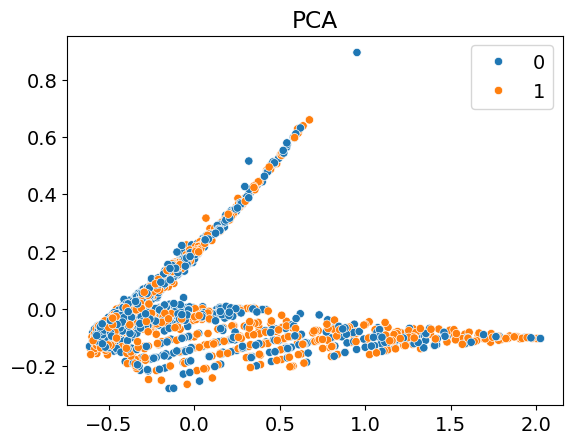

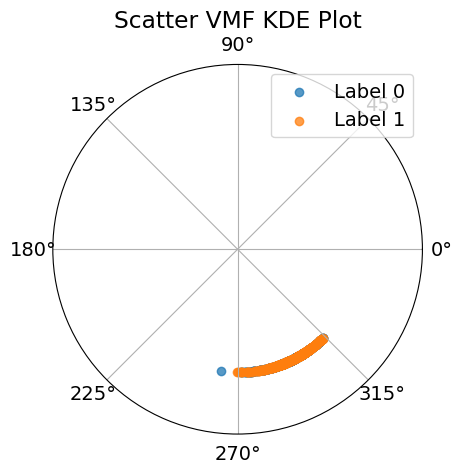

In [13]:
embeddings, labels = generate_embeddings(Contrastive_Graph_pl, val_loader)
pca_proj(embeddings, labels)
# tsne_proj(embeddings, labels)
vmf_kde_on_circle(embeddings, labels)

In [14]:
pretrained_model = GCN_Encoder()
# checkpoint_path = './logs/Contrastive_Graph_pl/version_0/checkpoints/epoch=14-step=14070.ckpt'
pretrained_model.load_state_dict(Contrastive_Graph_pl.model.state_dict())

num_classes = 2  # Adjust this based on your dataset

# Create an instance of the LinearProbePL module
linear_probe_model = LinearProbePL(pretrained_model=pretrained_model, num_classes=num_classes, learning_rate=0.001)

trainer_linear_probe = pl.Trainer(max_epochs=EPOCH, 
                            accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                            callbacks=callbacks,
                            logger=logger,)

train_result = trainer_linear_probe.fit(linear_probe_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
test_result = trainer_linear_probe.test(dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory logs/Contrastive_Graph_image_pl/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and

Sanity Checking: 0it [00:00, ?it/s]

Epoch 14: 100%|██████████| 251/251 [00:06<00:00, 36.68it/s, loss=0.686, v_num=0, val_loss=0.681, val_auc=0.588, val_acc=0.548, learning_rate=0.001, train_loss=0.685]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 251/251 [00:06<00:00, 36.56it/s, loss=0.686, v_num=0, val_loss=0.681, val_auc=0.588, val_acc=0.548, learning_rate=0.001, train_loss=0.685]


/home/ubuntu20_1/Miniconda3/envs/py39_qml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at logs/Contrastive_Graph_image_pl/version_0/checkpoints/epoch=14-step=2820-v4.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weig

Testing DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 46.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5540000200271606     │
│         test_auc          │     0.57610684633255      │
└───────────────────────────┴───────────────────────────┘

/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/demos/utils.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


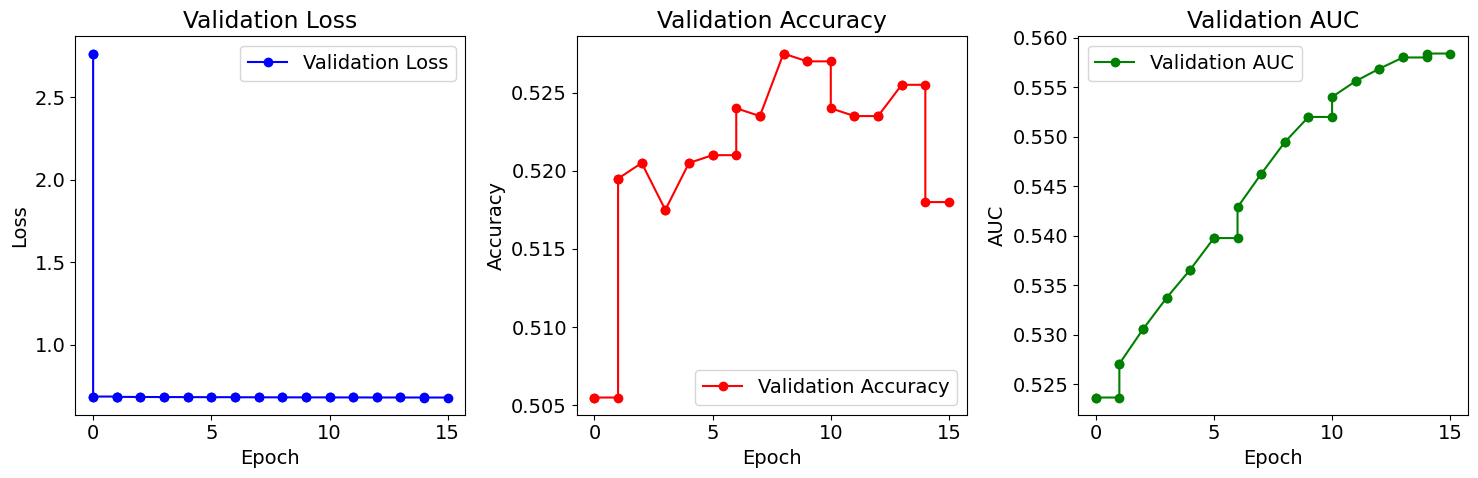

In [17]:
metrics_file = "./logs/Contrastive_Graph_image_pl/version_0/metrics.csv"

plot_metrics_from_csv(metrics_file)


/home/ubuntu20_1/Projects_Ubuntu20/gsoc24/qml-hep/gsoc24-qml-workspace/demos/utils.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


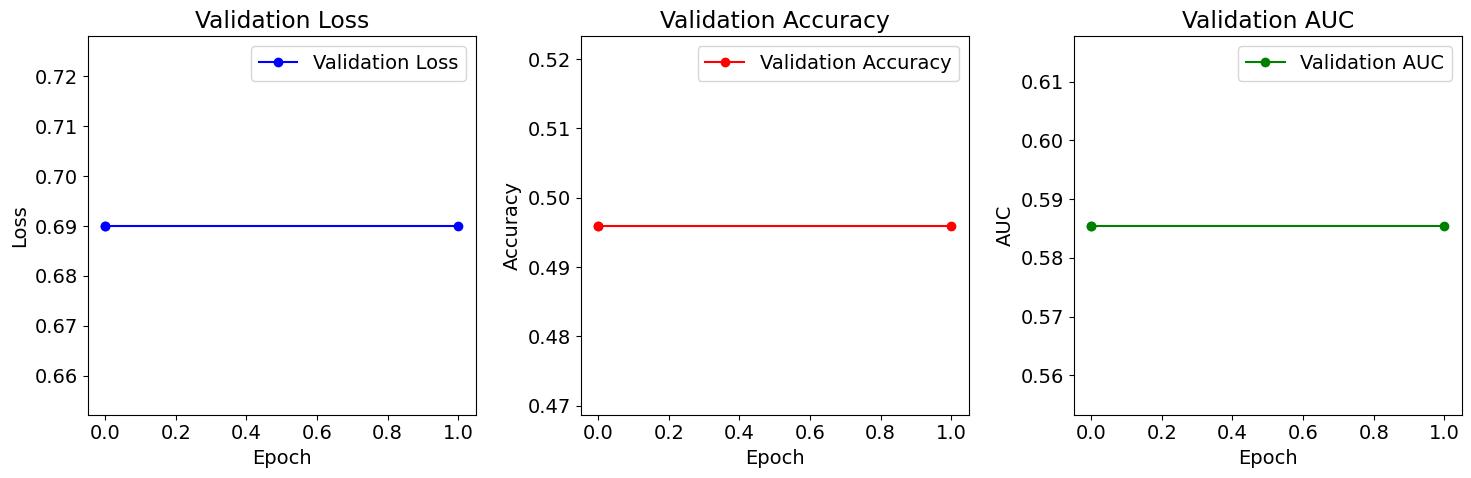

In [18]:
metrics_file = 'logs/graph_image_pl_2_100/version_0/metrics.csv' 

plot_metrics_from_csv(metrics_file)